In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

import sys
sys.path.insert(0, str(Path("__file__").parent))
from bbox_tools import letter_resize_bbox
from image_tools import letter_resize_img

In [2]:
from pycocotools.coco import COCO
import cv2
from abc import ABC


class COCOGenerator(ABC):

    def __init__(self, data_dir, setname, use_crowd):
        self.setname = setname
        self.data_dir = Path(data_dir)
        self.use_crowd = use_crowd
        self.annpath = self.data_dir / 'annotations' / f'instances_{setname}.json'
        self.coco = COCO(self.annpath)
        self.img_ids = self.coco.getImgIds()
        self.classes, self.class2id, self.id2class, self.class2label, self.label2class = [], {}, {}, {}, {}
        self.get_coco_info()
        self.num_class = len(self.classes)
        super(COCOGenerator, self).__init__()

    def get_coco_info(self):
        """
        pass
        """
        category_info = self.coco.loadCats(ids=self.coco.getCatIds())
        category_info.sort(key=lambda x: int(x['id']))
        for category in category_info:
            # self.classes.append(category['id'])
            self.class2id[len(self.classes)] = category['id']
            self.id2class[category['id']] = len(self.classes)
            self.class2label[len(self.classes)] = category['name']
            self.label2class[category['name']] = len(self.classes)
            self.classes.append(category['id'])

    def __len__(self):
        return len(self.img_ids)

    def size(self):
        """
        Size of COCO dataset.
        :return:
        """
        return len(self.img_ids)

    def has_label(self, label):
        return label in self.class2label

    def has_name(self, name):
        return name in self.label2class

    def label_to_name(self, label):
        return self.class2label[label]

    def name_to_label(self, name):
        return self.label2class[name]

    def coco_id_to_class(self, coco_id):
        return self.id2class[coco_id]

    def coco_id_to_label(self, coco_id):
        return self.class2label[self.coco_id_to_class(coco_id)]

    def get_img_path(self, idx):
        return str(self.data_dir / self.setname / f'{self.img_ids[idx]:>012}.jpg')

    def load_annotations(self, idx):
        """

        :param idx:
        :return: return box formate -> [xmin, ymin, xmax, ymax]
        """
        ann_ids = self.coco.getAnnIds(imgIds=self.img_ids[idx], iscrowd=self.use_crowd)
        img_info = self.coco.imgs[self.img_ids[idx]]
        annotations = {'classes': np.empty((0,), dtype=np.uint16), 'bboxes': np.empty((0, 4), dtype=np.float32)}
        # 有些img没有annotations
        if len(ann_ids) == 0:
            return annotations
        else:
            # anns is a list
            anns = self.coco.loadAnns(ids=ann_ids)
            for idx, ann in enumerate(anns):
                # 有些annotations中bbox的width/height值小于1，遇到这样的bbox就舍弃掉
                if (ann['bbox'][2]) < 1 or (ann['bbox'][3] < 1):
                    continue
                else:
                    annotations['classes'] = np.concatenate([annotations['classes'],
                                                             [self.coco_id_to_class(ann['category_id'])]],
                                                            axis=0)
                    annotations['bboxes'] = np.concatenate([annotations['bboxes'],
                                                            [[ann['bbox'][0],
                                                              ann['bbox'][1],
                                                              ann['bbox'][0] + ann['bbox'][2],
                                                              ann['bbox'][1] + ann['bbox'][3]]]],
                                                           axis=0)
        return annotations

### get the whole bbox in the dataset

In [3]:
from visualizer import plt_plot_img

if __name__ == "__main__":
    dataset_dir = Path('/Volumes/Samsung/Dataset/COCO')
    dst_size = [448, 448]
    coco = COCOGenerator(dataset_dir, "train2017", False)
    all_bboxes = []
    for i in tqdm(range(len(coco)), total=len(coco)):
        ann = coco.load_annotations(i)
        img_id = coco.img_ids[i]
        box = ann['bboxes']
        cls_ = ann['classes']
        img_src = coco.get_img_path(i)
        assert Path(img_src).exists()
        img_arr = cv2.imread(str(img_src))[..., ::-1]
        img_arr, info = letter_resize_img(img_arr, dst_size)
        box = letter_resize_bbox(box, info)
        # plt_plot_img(img_arr, box, [str(i) for i in cls_], [1 for i in cls_])
        all_bboxes.append(box)
        # break

    all_bboxes = np.concatenate(all_bboxes, axis=0)

loading annotations into memory...
Done (t=17.44s)
creating index...
index created!


100%|██████████| 118287/118287 [21:34<00:00, 91.35it/s] 


### show distribution

before fliter: (849902, 4)
after fliter: (846721, 4)


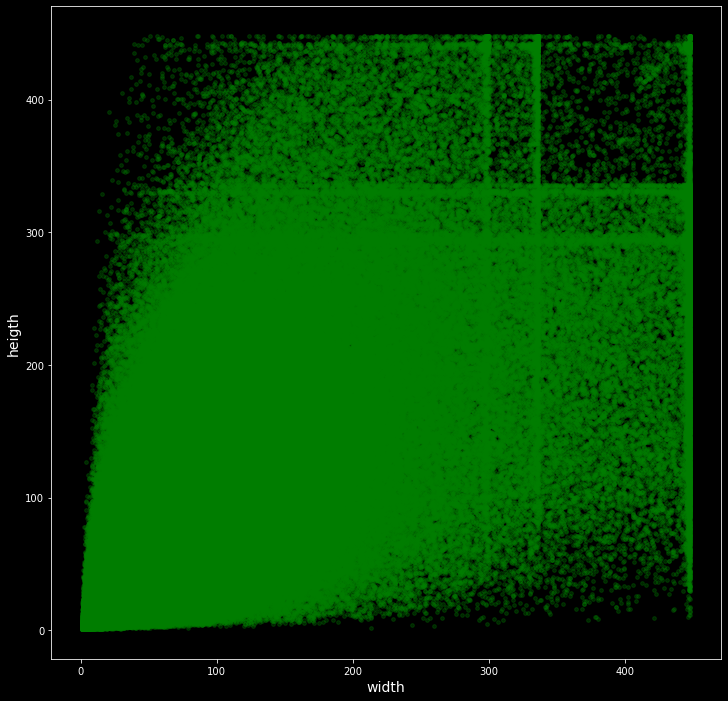

In [4]:
print(f"before fliter: {all_bboxes.shape}")

ws = all_bboxes[:, 2] - all_bboxes[:, 0]
hs = all_bboxes[:, 3] - all_bboxes[:, 1]
all_bboxes = all_bboxes[(ws >= 2) & (hs >= 2)]

print(f"after fliter: {all_bboxes.shape}")


fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(111)
ax.scatter(x=ws, y=hs, s=14, alpha = 0.3, c='g')
ax.set_xlabel('width', fontsize=14)
ax.set_ylabel('heigth', fontsize=14)
plt.show()

## Kmeans anchors

### iou

In [5]:

def iou(center_box, other_boxes):
    """compute iou between center_box and other_box
    :param center_box: ndarray / shape [k, 2]
    :param other_boxes: ndarray / shape [n, 2]
    :return: ndarray / shape [n, k]
    """
    # intersection_box = np.where(center_box < other_boxes, center_box, other_boxes)
    # (n, 2) -> (n, 1, 2) & (k, 2) -> (n, k, 2)
    intersection_box = np.minimum(other_boxes[:, None, :], center_box)
    intersection_area = np.prod(intersection_box, axis=2)  # (n, k)
    center_box_area = np.prod(center_box, axis=1)  # (k,)
    otherbox_areas = np.prod(other_boxes, axis=1)  # (n,)
    ious = intersection_area / (otherbox_areas[:, None] + center_box_area - intersection_area)
    return ious

### alias sample(for kmeans++)

In [6]:
def alias_setup(probs):
    """
    probs： 某个概率分布
    返回: Alias数组与Prob数组
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int32)
    smaller = []
    larger = []
    for i, prob in enumerate(probs):
        q[i] = K * prob  # 概率
        if q[i] < 1.0:
            smaller.append(i)
        else:
            larger.append(i)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] - (1.0 - q[small])

        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q


def alias_draw(J, q):
    '''
    输入: Prob数组和Alias数组
    输出: 一次采样结果
    '''
    K = len(J)
    k = int(np.floor(np.random.rand() * K))  # 随机取一列
    if np.random.rand() < q[k]:
        return k
    else:
        return J[k]

def alias_sample(probs, samples):
    assert isinstance(samples, int), 'Samples must be a integer.'
    sample_result = []
    J, p = alias_setup(probs)
    for i in range(samples):
        sample_result.append(alias_draw(J, p))
    return sample_result

In [7]:
def anchor_fitness(k: np.ndarray, wh: np.ndarray, thr_ratio: float, thr_iou: float):  # mutation fitness
    """
    :param k: anchor box / shape [k, 2]
    :param wh: all box / shape [n, 2]
    :param thr_ratio: threshold / float 0.25
    :param thr_iou: threshold / float 0.3
    :return: fitness
    """
    r = wh[:, None] / k[None]
    ratio_metric = np.minimum(r, 1. / r).min(2)  # ratio metric (n, k)
    iou_metric = iou(k, wh)  # iou metric (n, k)
    best_ratio = ratio_metric.max(1)  # best ratio (n,)
    best_iou = iou_metric.max(1)  # best iou (n,)
    f_ratio = (best_ratio * (best_ratio > thr_ratio).astype(np.float32)).mean()  # fitness
    f_iou = (best_iou * (best_iou > thr_iou).astype(np.float32)).mean()
    bpr_ratio = (best_ratio > thr_ratio).astype(np.float32).mean()  # best possible recall
    bpr_iou = (best_iou > thr_iou).astype(np.float32).mean()
    print(f"f_ratio: {f_ratio}, f_iou: {f_iou}, bpr_ratio: {bpr_ratio}, bpr_iou: {bpr_iou}")
    return f_ratio, bpr_ratio, f_iou, bpr_iou

In [8]:
def classification(k, bboxes, use_alias):
    length = len(bboxes)
    center_index = get_centers(k, bboxes, use_alias)
    print(f"center_index: {center_index}")
    center_coord = bboxes[center_index]  # (k, 2)
    
    times = 1
    last_class_list = np.zeros(shape=length)
    while True:
        dis = 1 - iou(center_coord, bboxes)  # (n, k)
        # print(dis.shape, dis.max(), dis.min(), dis.mean())
        cur_class_list = np.argmin(dis, axis=1)  # (n,)
        if (cur_class_list == last_class_list).all():
            break
        # update center
        for i in range(k):
            center_coord[i] = np.mean(bboxes[cur_class_list == i], axis=0)
        last_class_list = cur_class_list
        times += 1
    print(f"classification times: {times}")
    return last_class_list, center_coord


def show_result(class_list, raw_data, center_coordinate):
    print('Showing... ...')
    colors = [
              '#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#228B22',
              '#0000FF', '#FF1493', '#EE82EE', '#000000', '#FFA500',
              '#00FF00', '#006400', '#00FFFF', '#0000FF', '#FFFACD',
              ]

    use_color = []
    for node in class_list:
        use_color.append(colors[int(node)])
        
    plt.figure(num=1, figsize=(16, 9))
    plt.scatter(x=raw_data[:, 0], y=raw_data[:, 1], c=use_color, s=50, marker='o', alpha=0.3)
    plt.scatter(x=center_coordinate[:, 0], y=center_coordinate[:, 1], c='b', s=200, marker='+', alpha=0.8)
    plt.show()


def get_centers(k, bboxes, use_alias):
    if use_alias:
        centers = [random.randint(a=0, b=len(bboxes))]
        while len(centers) < k:
            dis = 1 - iou(bboxes[centers], bboxes)  # (n, k)
            min_dis = np.min(dis, axis = 1) # (n,)
            probs = min_dis / np.sum(min_dis)
            centers.append(alias_sample(probs, 1)[0])
        return np.array(centers).astype(np.int32)
    else:
        return np.random.choice(a=np.arange(len(bboxes)), size=k).astype(np.int32)
        


def kmeans(raw_data, k, use_alias=False, show=True):
    class_list, center_coordinate = classification(k, raw_data, use_alias)
    if show:
        show_result(class_list, raw_data, center_coordinate)
    return class_list, center_coordinate

### kmeans

In [9]:
whs = all_bboxes[:, [2, 3]] - all_bboxes[:, [0, 1]]

center_index: [405154 266120 712103 798077 656022 579535 315024 835044 218296]
classification times: 186
Showing... ...


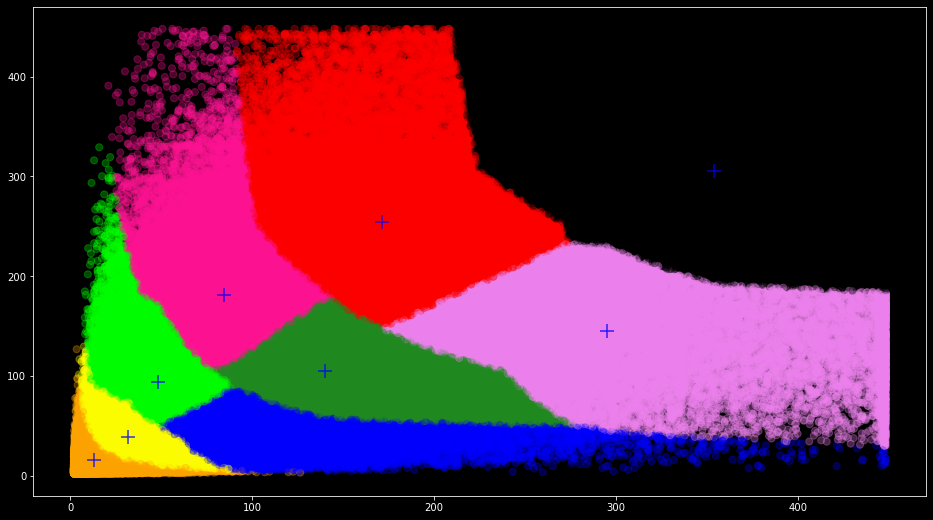

f_ratio: 0.6475360244541779, f_iou: 0.46445684959834665, bpr_ratio: 0.9791229963302612, bpr_iou: 0.6926897764205933
anchors: 
[[171.48464355 254.49973206]
 [ 12.99671928  15.42181269]
 [ 31.86606289  38.46689528]
 [ 48.43545669  94.25921159]
 [140.25103314 105.20062898]
 [ 93.38399813  47.82090375]
 [ 84.46097749 180.98448835]
 [294.66593945 144.96448024]
 [353.52140463 305.79616537]]


In [12]:
_, centers = kmeans(whs, 9)
anchor_fitness(centers, whs, 0.25, 0.5)
print(f"anchors: \n{centers}")

### kmeans++

center_index: [749516 230903 190620 123730 410433  73885 455251 748544 557992]
classification times: 402
Showing... ...


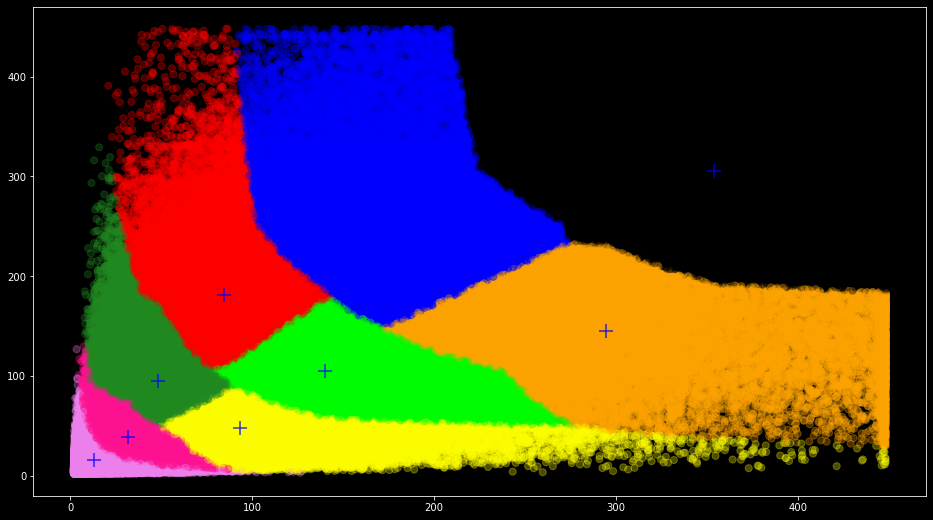

f_ratio: 0.6475373774038486, f_iou: 0.558461756537494, bpr_ratio: 0.979115903377533, bpr_iou: 0.9174237847328186
anchors: 
[[ 84.51282208 181.06705731]
 [294.6165737  144.88984504]
 [ 93.30239775  47.83434446]
 [140.19803102 105.17078719]
 [ 48.42642162  94.3492225 ]
 [171.54136557 254.47375764]
 [ 31.86012668  38.47830377]
 [ 12.99866724  15.42022416]
 [353.52305982 305.77522556]]


In [11]:
_, centers = kmeans(whs, 9, use_alias=True)
anchor_fitness(centers, whs, 0.25, 0.3)
print(f"anchors: \n{centers}")